# L8

Na tych ćwiczeniach omówimy:
* ensemble modelów,
* bagging,
* Random Forest,
* boosting (pokrótce).

Bardzo dobrym uzupełnieniem wiedzy z wykładu jest dokumentacja scikit-learn'a (omówiono tam zalety i wady tych metod, ponadto podano wiele przykładów i praktycznych wskazówek):
* drzewa decyzyjne - http://scikit-learn.org/stable/modules/tree.html
* metody ensemble - http://scikit-learn.org/stable/modules/ensemble.html

Wikipedia też daje radę:
* https://en.wikipedia.org/wiki/Gradient_boosting
* https://en.wikipedia.org/wiki/Xgboost

## Ensemble

<img width=600 src="figures/L8/ensemble.jpg">

Jeśli nauczyliśmy na tych samych danych kilka silnych modelów, to zazwyczaj warto uśrednić ich przewidywania. W zależności od problemu musimy zawsze zastanowić się, co to znaczy "uśrednić":
* klasyfikacja - głosowanie na klasę lub średnia arytmetyczna prawdopodobieńst predykcji poszczególnych klas,
* regresja MSE - średnia arytmetyczna,
* przewidywanie rankingu - średnia arytmetyczna miejsc w rankingach itp.

Średnią możemy liczyć z wagami i wtedy wag poszczególnych modelów szukamy dowolnym algorytmem doboru hiperparametrów. Zazwyczaj jednak nie jest to konieczne.

### Bagging

* bagging jest metodą redukcji wariancji, należy go stosować jedynie z silnymi modelami, które lubią overfittować,
* idea:
  * losujemy dane ze zbioru treningowego z powtórzeniami - jeśli losujemy N z N przykładów, to otrzymamy ok. 63% różnych wierszy (patrz wzór z ćwiczenia L2a/7), dzięki temu na niektórych przypadkach skupimy się bardziej (będą się powtarzały), a inne pominiemy,
  * możemy też wylosować część cech/kolumn (bez powtórzeń),
  * losowanie wykonujemy wielokrotnie i uczymy serię modelów, a na końcu uśredniamy ich predykcje,
* Leo Breiman, "Bagging Predictors": http://link.springer.com/article/10.1023%2FA%3A1018054314350
* "Improvement will occur for unstable procedures where a small change in learning set can result in large changes in
prediction. Instability was studied in Breiman [1994] where it was pointed out that neural nets, classification and
regression trees, and subset selection in linear regression were unstable, while k-nearest neighbor methods were stable.",
* nie wymaga modyfikacji podstawowego algorytmu uczącego,
* można uczyć równolegle,
* wymaga więcej zasobów.

### Boosting
* boosting polega na nauczeniu słabego modelu, a następnie poprawieniu go przy użyciu kolejnego słabego modelu, który przewiduje różnicę między predykcją na zbiorze treningowym i prawdziwymi etykietami,
* trzeba używać słabych modelów, które nie overfitują, ponieważ boosting zachęca do overfittingu,
* Philip M. Long, "Random Classification Noise Defeats All Convex Potential Boosters" http://www.cs.columbia.edu/~rocco/Public/mlj9.pdf
* "In 2008 Phillip Long (at Google) and Rocco A. Servedio (Columbia University) published a paper[17] at the 25th International Conference for Machine Learning suggesting that many of these algorithms are probably flawed. They conclude that "convex potential boosters cannot withstand random classification noise," thus making the applicability of such algorithms for real world, noisy data sets questionable. The paper shows that if any fraction of the training data is mis-labeled, the boosting algorithm tries extremely hard to correctly classify these training examples, and fails to produce a model with accuracy better than 1/2. This result does not apply to branching program based boosters but does apply to AdaBoost, LogitBoost, and others.",
* nie wymaga modyfikacji podstawowego algorytmu uczącego,
* trzeba uczyć sekwencyjnie, wymaga więcej zasobów.

### Gradient boosting vs Gradient descent
* licząc $-\frac{\partial L(y_{true}, y_{pred})}{\partial y_{pred}}$ uzyskamy kierunek, w którym powinniśmy troszkę poprawić $y_{pred}$ (predykcję modelu), aby zmniejszyć całkowity koszt,
* jeśli model jest różniczkowalny, to możemy "puścić" gradient dalej i obliczyć zmianę parametrów modelu, która spowoduje pożądaną zmianę $y_{pred}$ - tak uczymy np. sieci neuronowe, regresję liniową itp.
* jeśli model jest nieróżniczkowalny, to zazwyczaj nie umiemy go zmodyfikować tak, aby odpowiednio zmienić $y_{pred}$ - gradient boosting polega na nauczeniu drugiego modelu, który przybliży $-\frac{\partial L(y_{true}, y_{pred})}{\partial y_{pred}}$, a następnie przemnożeniu go przez pewną małą liczbę rzeczywistą (sterującą długością kroku) i dodaniem do modelu wyjściowego; proces powtarzamy wielokrotnie,
* stosujemy też trochę innych tricków, ale idea jest podobna,
* uwaga - zazwyczaj nie uda się dobrze przybliżyć $-\frac{\partial L(y_{true}, y_{pred})}{\partial y_{pred}}$ (w szczególności, że musimy używać słabych modelów), natomiast w przypadku modelów różniczkowalnych kierunek ten jest wyznaczony dokładnie.

### xgboost
* http://xgboost.readthedocs.io/en/latest/python/python_intro.html
* ma dużo sensownych hiperparametrów,
* jest lepszy od Random Forestów, prawie zawsze wygrywa lub jest częścią rozwiązania w konkursach na Kaggle'u,
* najlepsze narzędzie do prostych problemów klasyfikacji/regresji.

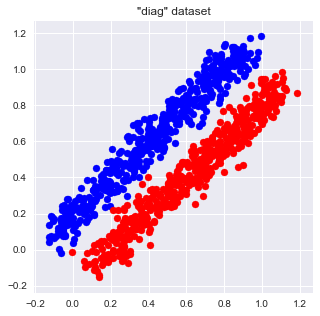

In [1]:
# importujemy potrzebne biblioteki
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline

# Dataset "breast cancer", był już w L7
data = pd.read_csv("data/L8/breast_cancer_transformer.csv")
data.drop("Unnamed: 32",axis=1,inplace=True)
data['diagnosis']=data['diagnosis'].map({'M':1,'B':0})
prediction_var = [
    u'radius_mean', u'texture_mean', u'perimeter_mean',
    u'area_mean', u'smoothness_mean', u'compactness_mean',
    u'concavity_mean', u'concave points_mean', u'symmetry_mean',
    u'fractal_dimension_mean', u'radius_se', u'texture_se', u'perimeter_se',
    u'area_se', u'smoothness_se', u'compactness_se', u'concavity_se',
    u'concave points_se', u'symmetry_se', u'fractal_dimension_se',
    u'radius_worst', u'texture_worst', u'perimeter_worst', u'area_worst',
    u'smoothness_worst', u'compactness_worst', u'concavity_worst',
    u'concave points_worst', u'symmetry_worst', u'fractal_dimension_worst'
]
train, test = train_test_split(data, test_size = 0.3)
bc_train_X = train[prediction_var].values
bc_train_y=train.diagnosis.values
bc_test_X= test[prediction_var].values
bc_test_y =test.diagnosis.values

# MNIST
mnist = fetch_mldata('MNIST original')
mnist_X = mnist["data"]
mnist_y = mnist["target"].astype(np.int64)

# Syntetyczny dataset "diag", 2 równoliczne klasy, rysunek poniżej
how_many = 500
rng = np.random.RandomState(43)
_X = rng.uniform(size=how_many).reshape(-1,1)
X1 = np.hstack((_X, _X))
X1 += np.array([-0.1, 0.1])
X1 += rng.normal(scale=0.05, size=X1.shape)
_X = rng.uniform(size=how_many).reshape(-1,1)
X2 = np.hstack((_X, _X))
X2 += np.array([0.1, -0.1])
X2 += rng.normal(scale=0.05, size=X1.shape)
diag_X = np.vstack((X1, X2))
diag_y = np.hstack((np.zeros(how_many), np.ones(how_many)))
plt.figure(figsize=(5,5))
plt.scatter(X1[:,0], X1[:,1], color="b")
plt.scatter(X2[:,0], X2[:,1], color="r")
plt.title('"diag" dataset')
plt.show()

W ćwiczeniach 1. i 2. należy po wytrenowaniu modelu pokolorować obszary decyzyjne. Można to zrobić na przykład tak: http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html


### Feature engineering

Drzewa decyzyjne zakładają, że kolumny tabeli X są na tyle "sensowne" - mocno skorelowane z etykietami (same z siebie lub pod warunkiem innych cech) - że do predykcji etykiety wystarczy porównywanie ich z pewnymi ustalonymi thresholdami (regresja liniowa, SVM itp. biorą kombinacje liniowe cech, sieci neuronowe uczą się cech wysokopoziomowych). 

Oczywiście nie zawsze jest to prawdą, dlatego warto spróbować dodać ręcznie nowe kolumny, na przykład:
* sumę/różnicę kilku kolumn,
* iloczyn kilku kolumn,
* logarytm kolumn,
* wielomian zależny od kilku kolumn,
* jeśli cechy opisują trójwymiarowy obiekt i mamy podane 3 wymiary, to może warto dodać objętość, średnicę itp.

Jest to analogiczne do zmiany zmiennych w regresji liniowej.

Zilustrujemy ten problem na przykładzie datasetu "diag" - zobaczymy, że drzewa decyzyjne mają problem z "ukośnymi" granicami decyzyjnymi.

In [2]:
from sklearn import decomposition
from sklearn import tree

## Ćwiczenie 1 [2 pkt]

Wytrenować:
* pojedyncze drzewo decyzyjne,
* Random Forest,
* pojedyncze drzewo decyzyjne po zamianie drugiej kolumny X na różnicę pierwszej i drugiej kolumny X

dla datasetu "diag" i zaznaczyć obszary decyzyjne (3 modele i 3 ilustracje).

In [3]:
x_min, x_max = diag_X[:, 0].min() - 1, diag_X[:, 0].max() + 1
y_min, y_max = diag_X[:, 1].min() - 1, diag_X[:, 1].max() + 1

X, y = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 1))

#### pojedyncze drzewo decyzyjne

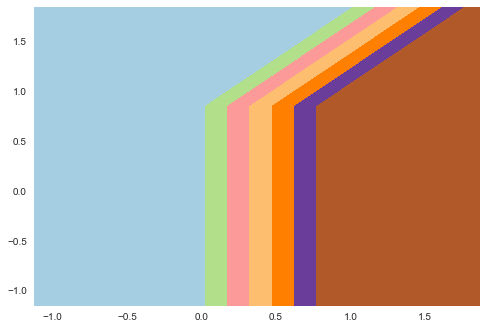

In [4]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(diag_X, diag_y)
Z = clf.predict(np.c_[X.ravel(), y.ravel()])
Z = Z.reshape(X.shape)
plt.contourf(X, y, Z, cmap=plt.cm.Paired)

#### Random Forest

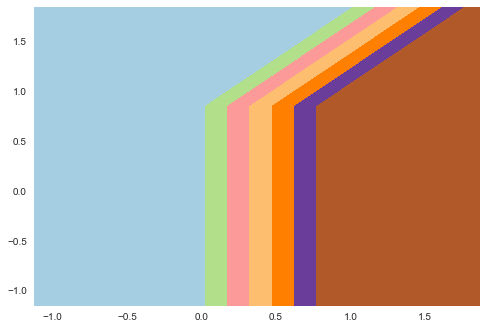

In [5]:
clf = RandomForestClassifier()
clf = clf.fit(diag_X, diag_y)

Z = clf.predict(np.c_[X.ravel(), y.ravel()])
Z = Z.reshape(X.shape)
plt.contourf(X, y, Z, cmap=plt.cm.Paired)

#### pojedyncze drzewo decyzyjne po zamianie drugiej kolumny X na różnicę pierwszej i drugiej kolumny X

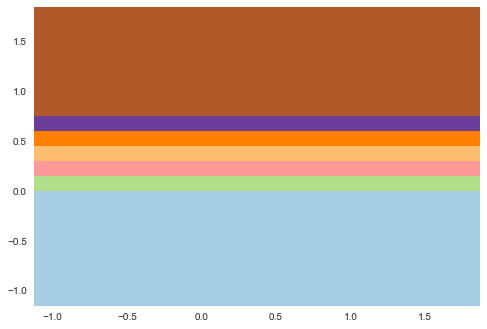

In [6]:
clf = tree.DecisionTreeClassifier()

col1 = diag_X[:,0]
col2 = diag_X[:,1] 

diag_X2 = []
for i in range(len(col1)):
    diag_X2.append([col1[i],col1[i] - col2[i]])

clf = clf.fit(diag_X2, diag_y)
diag_X2= np.array(diag_X2)

Z = clf.predict(np.c_[X.ravel(), y.ravel()])
Z = Z.reshape(X.shape)
plt.contourf(X, y, Z, cmap=plt.cm.Paired)

Jeśli cechy (kolumny X) nie są "sensowne", to być może warto zastosować metody redukcji wymiarowości typu PCA, ICA (czy były na Analizie Danych?). PCA spełnia dwie funkcje:
* wyszukuje **kombinacje liniowe** cech, które mają dużą wariancję, a więc potencjalnie mogą być bardziej skorelowane z etykietami (przykład: https://en.wikipedia.org/wiki/Eigenface) - to działa nawet, gdy nie zmniejszamy liczby cech!
* redukcja wymiaru może zmniejszyć overfitting.

Oczywiście może się też zdarzyć, że PCA bardziej przeszkadza, niż pomaga - użycie redukcji wymiarowości danych należy zawsze traktować jako kolejny hiperparametr.

## Ćwiczenie 2 [2 pkt]

Używając klasy Pipeline połączyć PCA (bez zmniejszania wymiaru) z pojedynczym drzewem decyzyjnym i wytrenować na datasecie "diag". Zaznaczyć kolorem obszary decyzyjne. Wytłumaczyć wynik.

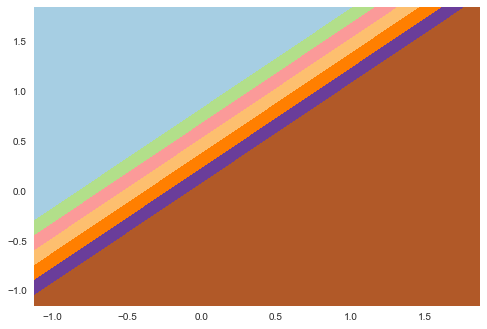

In [7]:
clf = tree.DecisionTreeClassifier()
pca = decomposition.PCA()

pipe = Pipeline(steps=[('pca', pca), ('tree', clf)])
pipe.fit(diag_X, diag_y)

Z = pipe.predict(np.c_[X.ravel(), y.ravel()])
Z = Z.reshape(X.shape)
cs = plt.contourf(X, y, Z, cmap=plt.cm.Paired)

### Random Forest

Dodanie większej liczby drzew powoduje zwiększenie liczby parametrów modelu. Mogłoby się wydawać, że spowoduje to w końcu overfitting i spadek skuteczności na zbiorze testowym, ale okazuje się, że Random Forest jest na to stosunkowo odporny.

Z reguły im więcej użyjemy drzew, tym lepiej dla predykcji, ale tym gorzej dla naszych zasobów (czas uczenia, RAM, storage nauczonego modelu itp.).

Jak dobierać parametry: http://scikit-learn.org/stable/modules/ensemble.html#parameters

Parallelization: http://scikit-learn.org/stable/modules/ensemble.html#parallelization

Proszę w szczególności zwrócić uwagę na parametr "oob_score".

## Ćwiczenie 3 [2 pkt]

Na datasecie "breast cancer" należy wytrenować dwie serie modelów: Random Forest oraz ensemble regresji logistycznych (BaggingClassifier w połączeniu z LogisticRegression). Należy włączyć liczenie oob_score, można też uczyć wielowątkowo. Należy zostawić domyślne wartości wszystkich hiperparametrów poza liczbą estymatorów.

Narysować wykres:
* poziomo - liczba estymatorów (w zakresie np. 1-50, można przeskakiwać co kilka),
* pionowo sześć rzeczy:
    * Random Forest training score,
    * Random Forest test score,
    * Random Forest oob_score,
    * Ensemble LR training score,
    * Ensemble LR test score,
    * Ensemble LR oob_score,

dodać ładną legendę itp.

### Feature selection

Random Forest potrafi po wytrenowaniu ocenić, które cechy ze zbioru treningowego były najistotniejsze dla poprawnej predykcji. Wiedzę tę możemy wykorzystać na wiele sposobów:
* jeśli próbujemy zinterpretować dane i model, możemy skupić się tylko na najważniejszych cechach,
* jeśli projektujemy maszynę i chcemy dołączyć do niej system wczesnego ostrzegania przed awarią, to możemy na etapie projektowania zamontować bardzo dużo kosztownych czujników, wytrenować Random Forest (przewidywanie awarii z odczytów z czujników) i w produkcji masowej zostawić tylko te najistotniejsze sensory,
* czasem możemy poprawić wynik Random Forest'u działając w następujący sposób: trenujemy pierwszy raz, usuwamy wszystkie nieistotne cechy (musimy ręcznie dobrać poziom istotności), trenujemy drugi raz tylko na istotnych cechach,
* itp.

## Ćwiczenie 4 [2 pkt]

Wytrenować Random Forest (30 lub 100 drzew) na datasecie MNIST. Narysować istotność poszczególnych pikseli. Ograniczyć się tylko do cyfr 6, 8, 9 i zrobić to samo, wyjaśnić różnicę.

Przykład dla zdjęć twarzy: http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances_faces.html

Oczekiwany efekt:
<img width=300 src="figures/L8/mnist_features.png">
<img width=300 src="figures/L8/mnist_features_689.png">


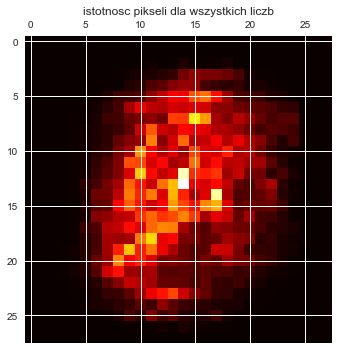

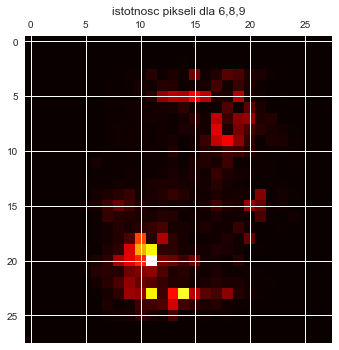

In [10]:
clf = RandomForestClassifier(n_estimators=30)
clf = clf.fit(mnist_X, mnist_y)

imp = clf.feature_importances_
imp = imp.reshape(mnist.data[0].reshape(-1,28).shape)

plt.matshow(imp, cmap=plt.cm.hot)
plt.title("istotnosc pikseli dla wszystkich liczb")
plt.show()


mnist_X2 = []
mnist_y2 = []

for i in range(len(mnist_X)):
    if(mnist.target[i] in [6,8,9]):
        mnist_X2.append(mnist_X[i])
        mnist_y2.append(mnist_y[i])


clf = RandomForestClassifier(n_estimators=30)
clf = clf.fit(mnist_X2, mnist_y2)

imp = clf.feature_importances_
imp = imp.reshape(mnist.data[0].reshape(-1,28).shape)

plt.matshow(imp, cmap=plt.cm.hot)
plt.title("istotnosc pikseli dla 6,8,9")
plt.show()

#### Wyjaśnienie
Cyfry sa róznorodne, żeby rozruznic je wszystkie potrzebujemy informacji z całej przestrzeni na której sie pojawiają. W przypadku cyfr 6,8,9 znaczace są tyleko dwie informacje, które je rozrózniaja:
* prawy górny róg - odróznia 6 od 8 i 9, 
* lewy dolny róg - odróznia 9 od 6 i 8.

## Ćwiczenie 5 [1 pkt]

Ułożyć wierszyk o lasach losowych. Wierszyk musi się rymować i mieć min. 8 wersów, można w nim pochwalić bibliotekę xgboost.

Oczekiwany efekt: http://literat.ug.edu.pl/staff/080.htm

Haiku:  
green, brown, yellow, red  
the beauty of autumn trees  
want more - xgboost  

Wiersz:  
Lesie, lesie, lesie zielony  
Lesie, lesie, lesie losowy  
Lesie, cóż więcej ma wyjść z moich ust?  
Najlepsza jest bilioteka xgboost!  

Więcej pomysłów na wiersz mi nie stało,  
Lecz aby wersów nie było zbyt mało,  
Piszę tę oto tutaj bezsensowną zwrotkę,  
By zadanie domowe zaliczyć na piątkę!  